In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB). PLEASE USE APPROPRIATE PATH TO TASK1

In [3]:
#set title for saving model 
title = "mel_vs_nev&seb_no_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import numpy as np
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#ViT model initialization
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
#Adding additional layers to ViT
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [9]:
#compile the model using binary cross entropy function
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8) #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                             #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#Plotting garph for train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)       #calculating ROC score

    precision = precision_score(test_labels, predicted_labels, average='weighted')          #Calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged/task1"
test_dir = "/content/drive/MyDrive/msc_project/test/task1"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.5278
Epoch 1: val_accuracy improved from -inf to 0.62000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_1.hdf5
18/18 [==============================] - 94s 2s/step - loss: 0.8388 - accuracy: 0.5278 - val_loss: 0.7956 - val_accuracy: 0.6200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.8037 - accuracy: 0.5556
Epoch 2: val_accuracy improved from 0.62000 to 0.66000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_1.hdf5
18/18 [==============================] - 24s 1s/step - loss: 0.8037 - accuracy: 0.5556 - val_l

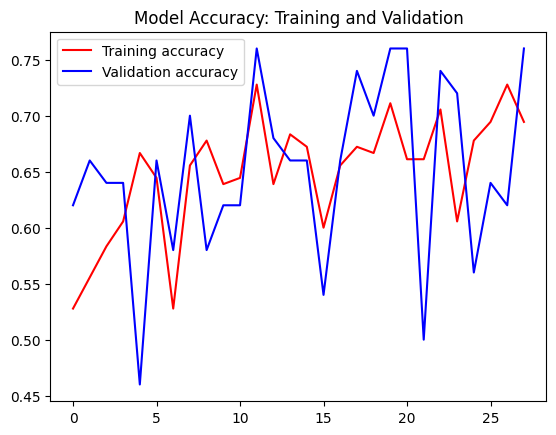

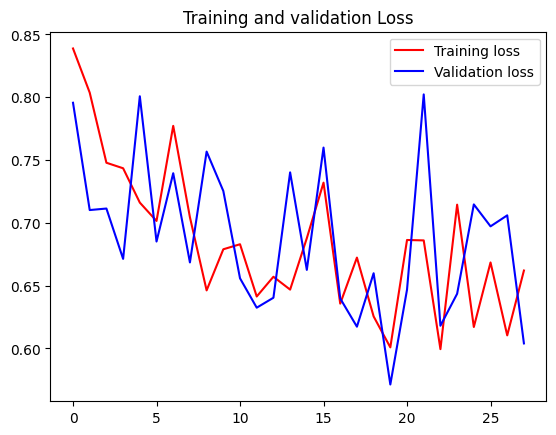

<Figure size 640x480 with 0 Axes>

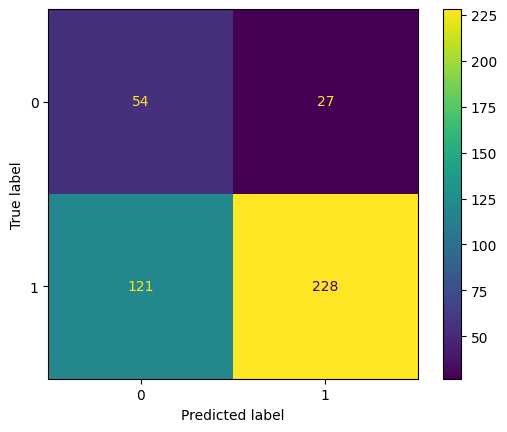


               precision    recall  f1-score   support

           0       0.31      0.67      0.42        81
           1       0.89      0.65      0.75       349

    accuracy                           0.66       430
   macro avg       0.60      0.66      0.59       430
weighted avg       0.78      0.66      0.69       430

Sensitivity: 0.653 Specificity: 0.667 Precision: 0.784 ROC_AUC_SCORE: 0.725



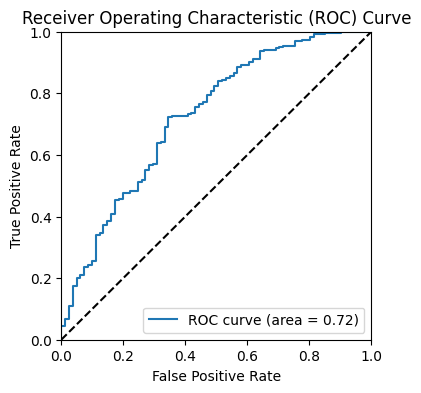

Validation complete...
Traning for Fold: 2
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6944
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_2.hdf5
18/18 [==============================] - 71s 1s/step - loss: 0.6383 - accuracy: 0.6944 - val_loss: 0.5944 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6944
Epoch 2: val_accuracy did not improve from 0.82000
18/18 [==============================] - 9s 521ms/step - loss: 0.6341 - accuracy: 0.6944 - val_loss: 0.5632 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 3: LearningRateSch

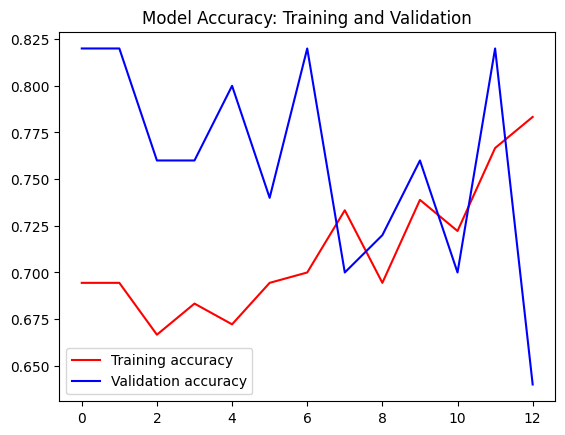

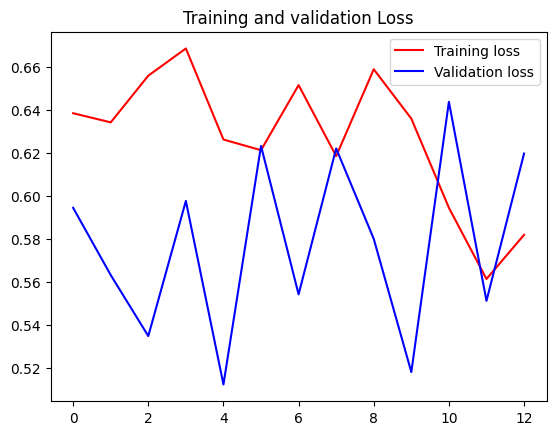

<Figure size 640x480 with 0 Axes>

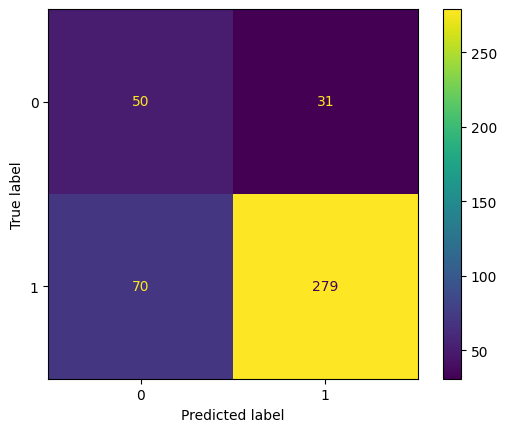


               precision    recall  f1-score   support

           0       0.42      0.62      0.50        81
           1       0.90      0.80      0.85       349

    accuracy                           0.77       430
   macro avg       0.66      0.71      0.67       430
weighted avg       0.81      0.77      0.78       430

Sensitivity: 0.799 Specificity: 0.617 Precision: 0.809 ROC_AUC_SCORE: 0.795



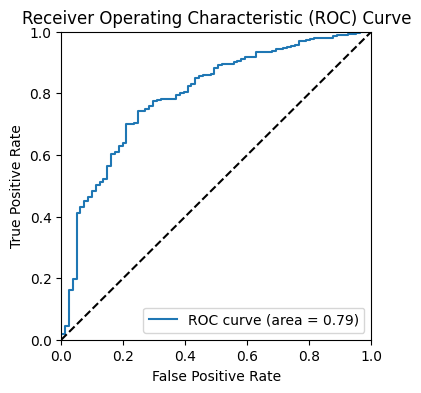

Validation complete...
Traning for Fold: 3
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.6389
Epoch 1: val_accuracy improved from -inf to 0.62000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_3.hdf5
18/18 [==============================] - 67s 1s/step - loss: 0.7112 - accuracy: 0.6389 - val_loss: 0.6154 - val_accuracy: 0.6200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7056
Epoch 2: val_accuracy improved from 0.62000 to 0.74000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_3.hdf5
18/18 [==============================] - 11s 627ms/step - loss: 0.6648 

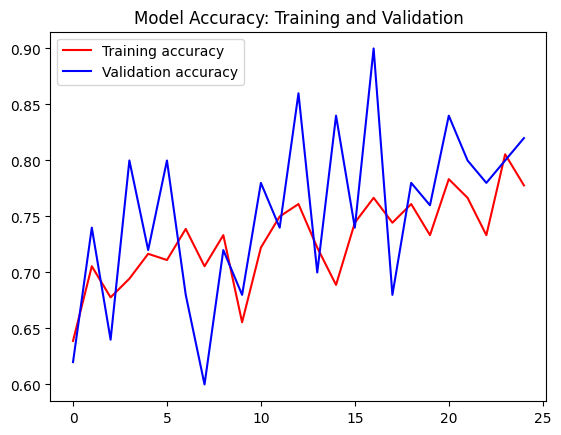

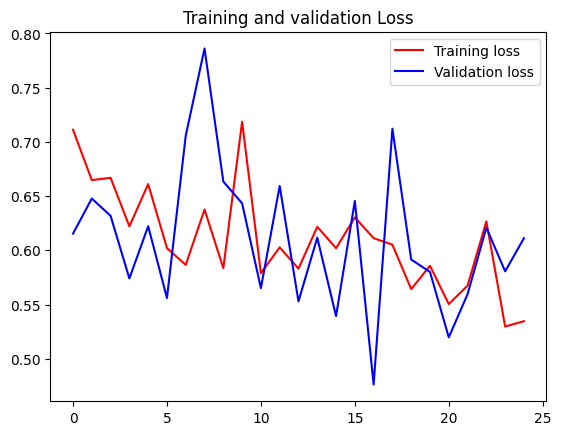

<Figure size 640x480 with 0 Axes>

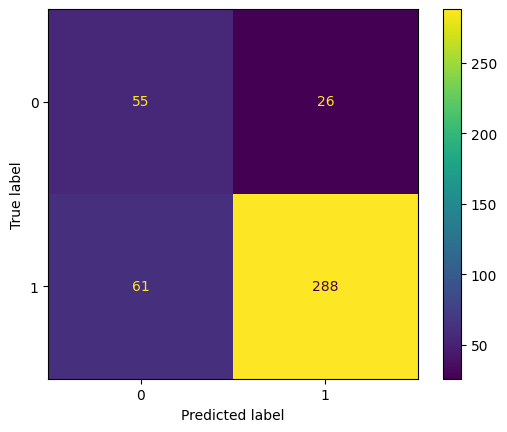


               precision    recall  f1-score   support

           0       0.47      0.68      0.56        81
           1       0.92      0.83      0.87       349

    accuracy                           0.80       430
   macro avg       0.70      0.75      0.71       430
weighted avg       0.83      0.80      0.81       430

Sensitivity: 0.825 Specificity: 0.679 Precision: 0.834 ROC_AUC_SCORE: 0.814



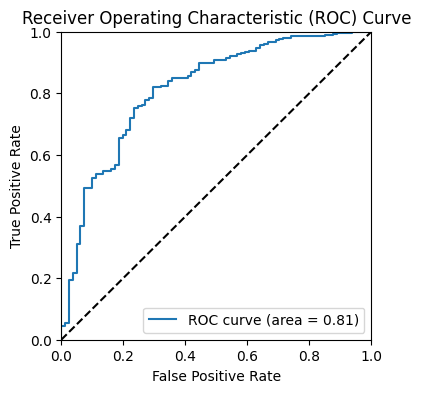

Validation complete...
Traning for Fold: 4
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.7333
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_4.hdf5
18/18 [==============================] - 64s 805ms/step - loss: 0.5778 - accuracy: 0.7333 - val_loss: 0.5015 - val_accuracy: 0.8000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.7556
Epoch 2: val_accuracy improved from 0.80000 to 0.88000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_4.hdf5
18/18 [==============================] - 11s 619ms/step - loss: 0.58

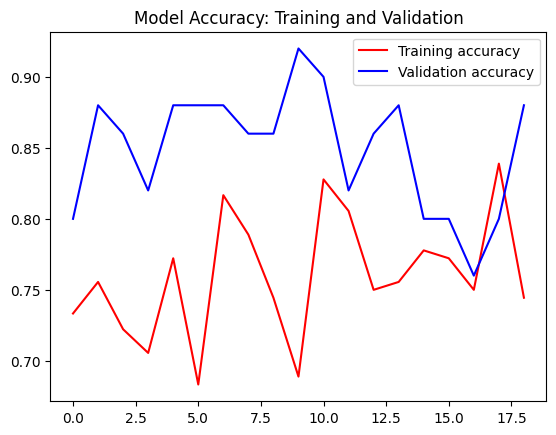

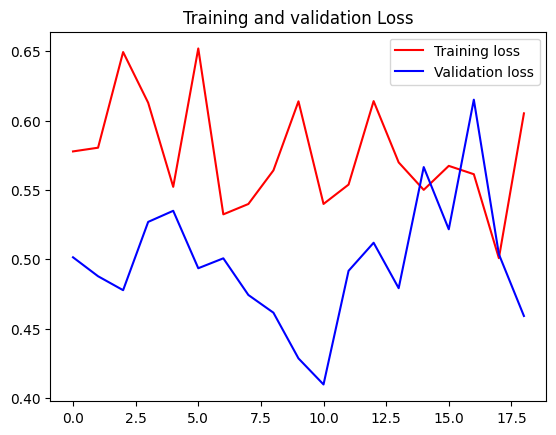

<Figure size 640x480 with 0 Axes>

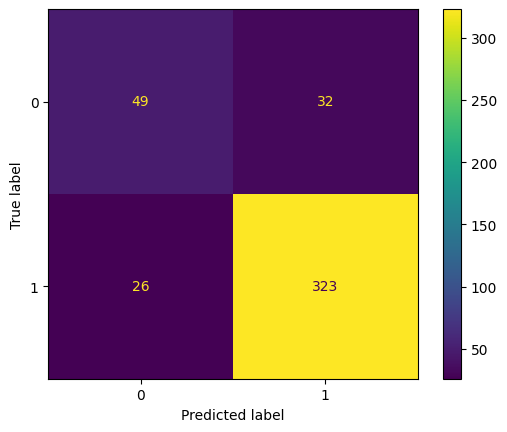


               precision    recall  f1-score   support

           0       0.65      0.60      0.63        81
           1       0.91      0.93      0.92       349

    accuracy                           0.87       430
   macro avg       0.78      0.77      0.77       430
weighted avg       0.86      0.87      0.86       430

Sensitivity: 0.926 Specificity: 0.605 Precision: 0.862 ROC_AUC_SCORE: 0.831



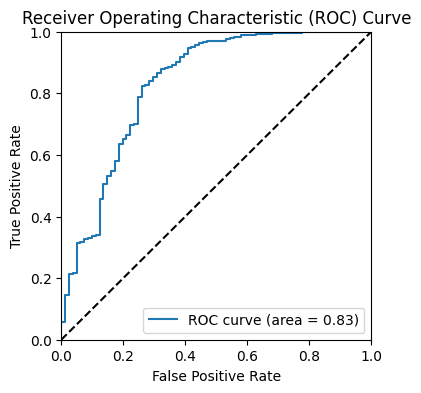

Validation complete...
Traning for Fold: 5
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7111
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_5.hdf5
18/18 [==============================] - 63s 827ms/step - loss: 0.6214 - accuracy: 0.7111 - val_loss: 0.5391 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.7667
Epoch 2: val_accuracy did not improve from 0.82000
18/18 [==============================] - 9s 503ms/step - loss: 0.5506 - accuracy: 0.7667 - val_loss: 0.5267 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 3: LearningRate

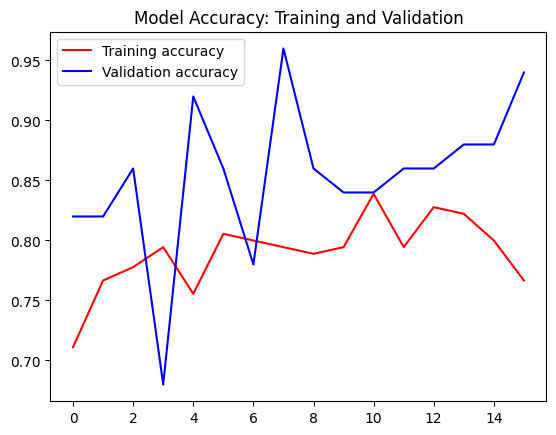

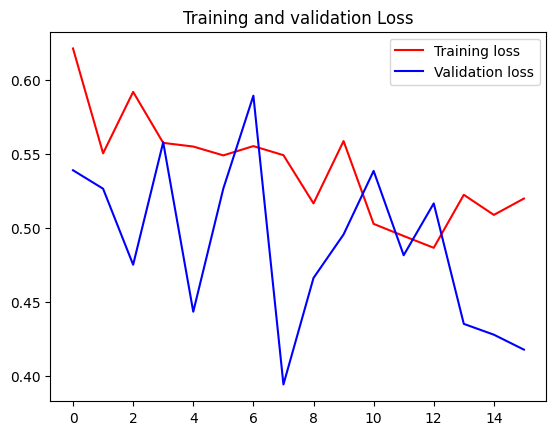

<Figure size 640x480 with 0 Axes>

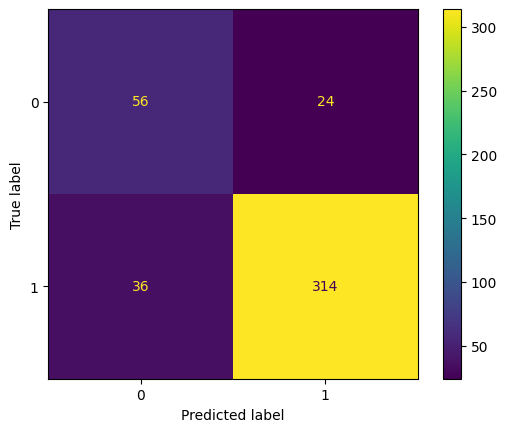


               precision    recall  f1-score   support

           0       0.61      0.70      0.65        80
           1       0.93      0.90      0.91       350

    accuracy                           0.86       430
   macro avg       0.77      0.80      0.78       430
weighted avg       0.87      0.86      0.86       430

Sensitivity: 0.897 Specificity: 0.7 Precision: 0.869 ROC_AUC_SCORE: 0.876



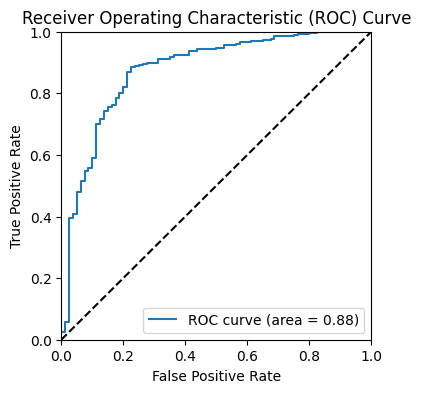

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    #Evaluation the model with this validation data with shuffle = false
    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    #plot the graph of train and validation accuracy and loss
    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [18]:
test_dir

'/content/drive/MyDrive/msc_project/test/task1'

In [19]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 141s 236ms/step


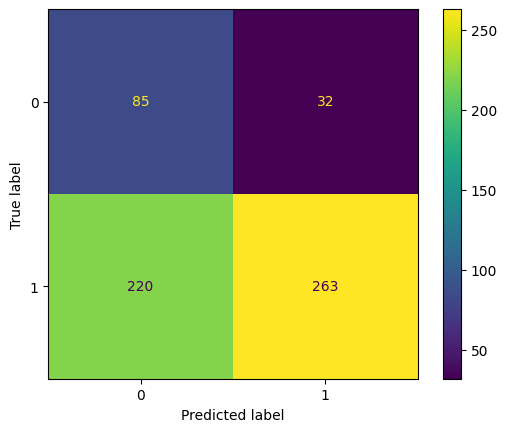


               precision    recall  f1-score   support

           0       0.28      0.73      0.40       117
           1       0.89      0.54      0.68       483

    accuracy                           0.58       600
   macro avg       0.59      0.64      0.54       600
weighted avg       0.77      0.58      0.62       600

Sensitivity: 0.545 Specificity: 0.726 Precision: 0.772 ROC_AUC_SCORE: 0.693



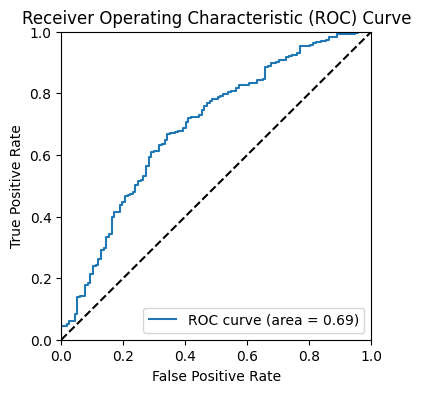

Testing Complete
Test using model 2
600/600 [==============================] - 26s 43ms/step


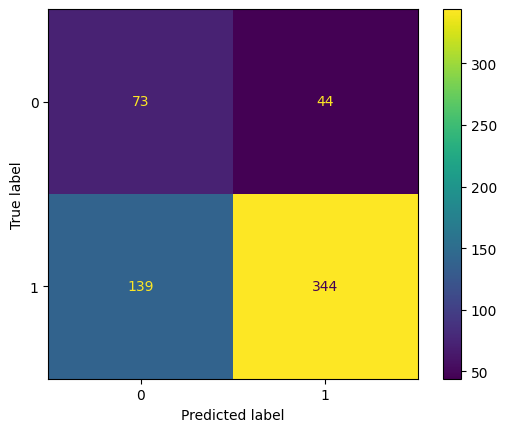


               precision    recall  f1-score   support

           0       0.34      0.62      0.44       117
           1       0.89      0.71      0.79       483

    accuracy                           0.69       600
   macro avg       0.62      0.67      0.62       600
weighted avg       0.78      0.69      0.72       600

Sensitivity: 0.712 Specificity: 0.624 Precision: 0.781 ROC_AUC_SCORE: 0.696



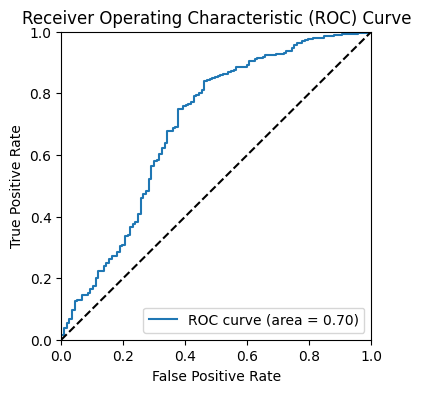

Testing Complete
Test using model 3
600/600 [==============================] - 26s 43ms/step


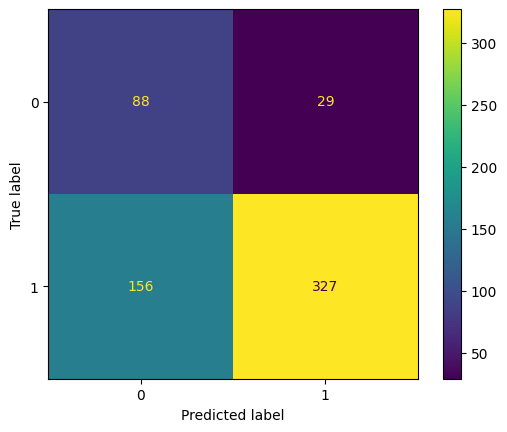


               precision    recall  f1-score   support

           0       0.36      0.75      0.49       117
           1       0.92      0.68      0.78       483

    accuracy                           0.69       600
   macro avg       0.64      0.71      0.63       600
weighted avg       0.81      0.69      0.72       600

Sensitivity: 0.677 Specificity: 0.752 Precision: 0.81 ROC_AUC_SCORE: 0.783



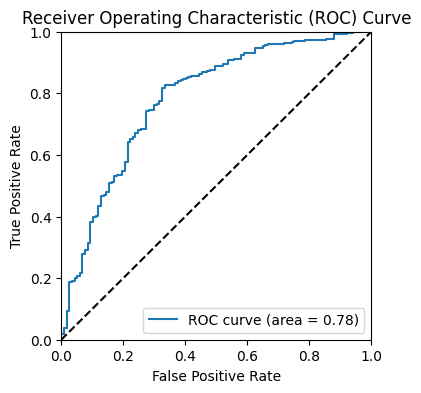

Testing Complete
Test using model 4
600/600 [==============================] - 26s 43ms/step


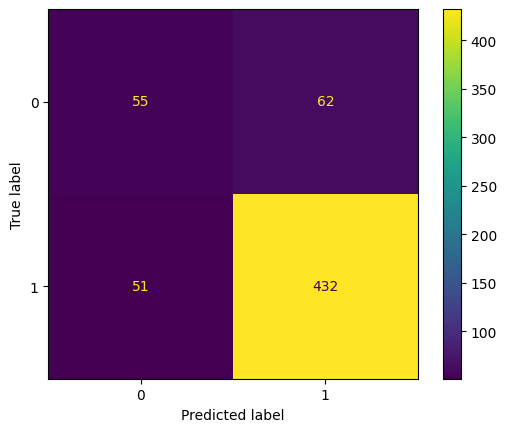


               precision    recall  f1-score   support

           0       0.52      0.47      0.49       117
           1       0.87      0.89      0.88       483

    accuracy                           0.81       600
   macro avg       0.70      0.68      0.69       600
weighted avg       0.81      0.81      0.81       600

Sensitivity: 0.894 Specificity: 0.47 Precision: 0.805 ROC_AUC_SCORE: 0.774



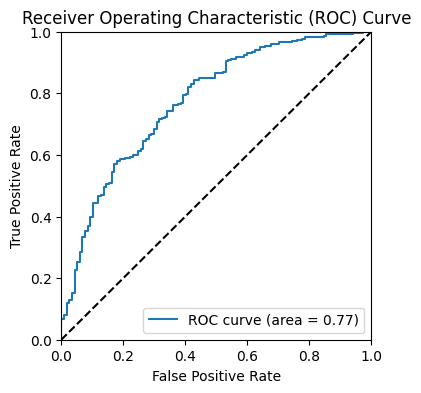

Testing Complete


In [20]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")